# Interactive Plot to compare failures in Bonn method and our method
- Loads PCA model and dataset of leaf point clouds
- Computes matches
- Creates contour plots and highlights correct and false matches

In [53]:
import leaf_encoding
import visualise
import open3d as o3d

In [54]:
import leaf_matching
import packages.pheno4d_util as putil

%matplotlib notebook
from ipywidgets import *
import numpy as np
import copy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

Load data

In [55]:
directory = os.path.join('/home', 'karolineheiwolt','workspace', 'data', 'Pheno4D', '_processed', 'pca_input')
PCAH, test_ds, test_labels = leaf_encoding.get_encoding(train_split=0.754, random_split=False, directory=directory, standardise=True,  \
                            location=True, rotation=True, scale=True, as_features=False)
data = test_ds
labels = test_labels

In [56]:
IDs = [0,3,None,None,0,4,None,None] # Plant, timestep, day, leafnr
annotations = 3 # 0 for plant number, 1 for timestep, 2 for day, 3 for leaf number

c_directory = os.path.join('/home', 'karolineheiwolt','workspace', 'data', 'Pheno4D', '_processed', 'transform_log')
centroids, centroid_labels = leaf_matching.get_location_info(directory) # already sorted

indeces = np.asarray([np.argwhere((centroid_labels == leaf).all(axis=1)) for leaf in labels]).flatten()
centroids = centroids[indeces,:]
centroid_labels = centroid_labels[indeces,:]

<IPython.core.display.Javascript object>


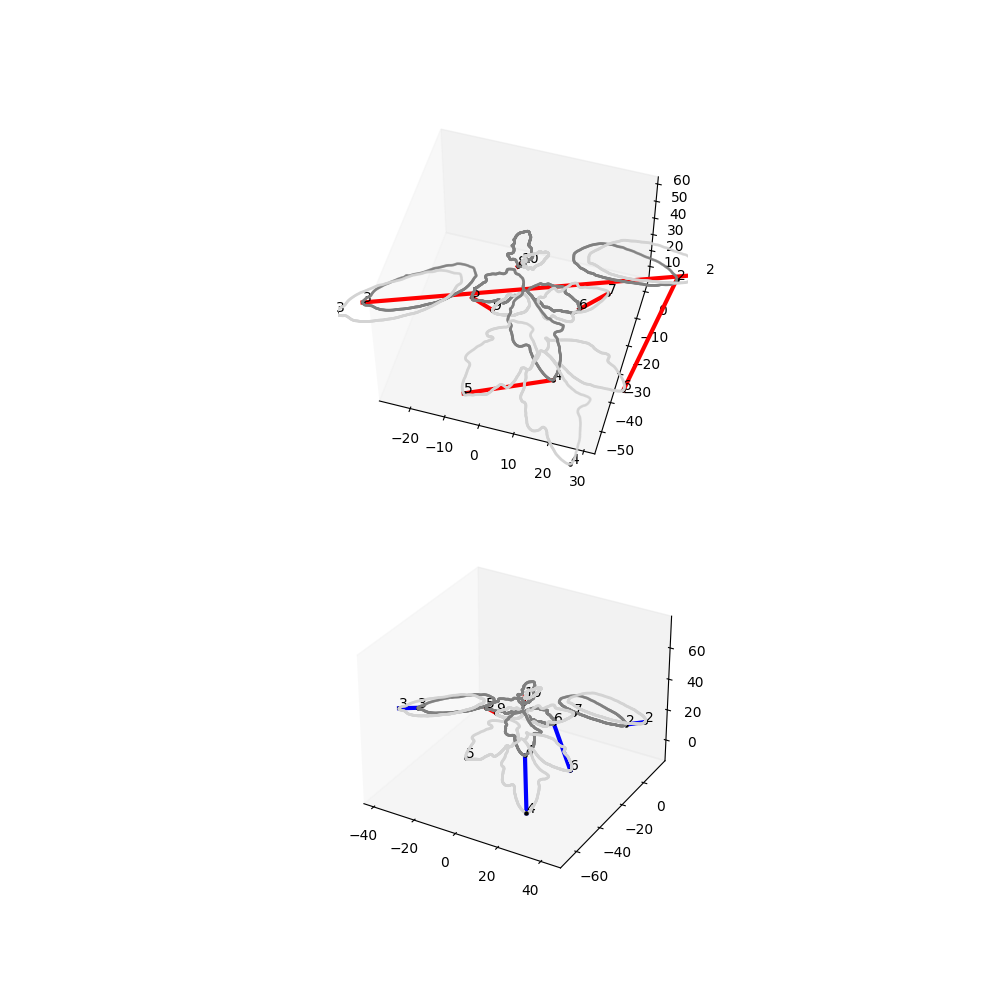

interactive(children=(Checkbox(value=True, description='box1'), BoundedIntText(value=0, description='Plant Num…

<function __main__.update(box1, plant, box2, timestep, box3, day, box4, leaf, box5, plant2, box6, timestep2, box7, day2, box8, leaf2)>

In [57]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(2, 1, 1, projection='3d')
ax2 = fig.add_subplot(2, 1, 2, projection='3d')
ax_3d = [ax,ax]
ax_3d_2 = [ax2,ax2]

def update(box1, plant, box2, timestep, box3, day, box4, leaf, box5, plant2, box6, timestep2, box7, day2, box8, leaf2):
    toggles = [(box1, box2, box3, box4), (box5, box6, box7, box8)]
    parameters = [(plant, timestep, day, leaf), (plant2, timestep2, day2, leaf2)]
    components = 23
    IDs = [[None if box == False else params[i] for i,box in enumerate(toggle)]for params,toggle in zip(parameters, toggles)]

    datasets = []
    centroid_lst = []
    for ID in IDs:
        subset, sub_labels = leaf_encoding.select_subset(data, labels, plant_nr = ID[0], timestep=ID[1], day=ID[2], leaf=ID[3])
        sub_c, sub_c_labels = leaf_encoding.select_subset(centroids, centroid_labels, plant_nr = ID[0], timestep=ID[1], day=ID[2], leaf=ID[3])
        datasets.append((subset,sub_labels))
        centroid_lst.append((sub_c,sub_c_labels))
        if subset.size == 0:
            print('WARNING: One of your selected subsets is empty!')
            break

    max_color = np.max((np.max(datasets[0][1][:,3]), np.max(datasets[1][1][:,3])))
    cmap = cm.get_cmap('rainbow')
    
    data_copy = copy.deepcopy(datasets)
    
    save_pcs = False
    offset = False
    show_decompressed = False
    i=0
    for ax in ax_3d:
        ax.clear()
    for ax in ax_3d_2:
        ax.clear()
    for ax_lst in [ax_3d,ax_3d_2]:
        j=0
        for subset, ax in zip(data_copy, ax_lst):
            #ax.clear()
            ax.grid(False)
            #ax.axis('off')
            if j==0:
                col = 'grey'
            else:
                col = 'lightgrey'
            j+=1
            cum_offset = 0
            width = 0
            for leaf,label in zip(subset[0],subset[1]):

                if show_decompressed:
                    ax.title.set_text('This plot shows not the original 3D outline shapes, but projected 3D outlines after PCA and subsequent decrompression')
                    weights = PCAH.compress(leaf, components)
                    reprojection = PCAH.decompress(weights, components) # shape (1xfeatures)
                    decompressed_outline, add_f = leaf_encoding.reshape_coordinates_and_additional_features(reprojection)
                    outline = np.squeeze(decompressed_outline) # Remove extra dimension 1x500x3 to 500x3
                else:
                    outline = leaf_encoding.reshape_coordinates_and_additional_features(leaf)[0] # 500x3

                if save_pcs:
                    pcd = visualise.array_to_o3d_pointcloud(outline)
                    o3d.io.write_point_cloud(f"pcds/{label}.pcd", pcd)

                if offset:
                    cum_offset += 0.6 * width
                    width = (np.max(outline[:,0]) - np.min(outline[:,0]))
                    cum_offset += 0.6 * width
                    outline[:,0] += cum_offset
                scatterplot = ax.scatter(xs=outline[:,0], ys=outline[:,1], zs=outline[:,2], s=1, color=col)
                start_point = ax.scatter(xs=outline[0][0], ys=outline[0][1], zs=outline[0][2], s=5, color='black')
                out = ax.text(outline[0,0], outline[0,1], outline[0,2], s=str(label[annotations]), color='black')
            visualise.set_axes_equal(ax)

        # get assignments
        cdist = leaf_matching.make_dist_matrix(centroid_lst[0][0], centroid_lst[1][0], centroids, mahalanobis_dist = False, draw=False)
        odist = leaf_matching.make_fs_dist_matrix(datasets[0][0], datasets[1][0], PCAH, mahalanobis_dist = True, draw=False, components=components)

        match, match_array, c_legible_matches = leaf_matching.compute_assignment(cdist, centroid_lst[0][1], centroid_lst[1][1])
        match, match_array, o_legible_matches = leaf_matching.compute_assignment(odist, datasets[0][1], datasets[1][1])

        if i==0:
            matches = c_legible_matches[:,:,-1]
        else:
            matches = o_legible_matches[:,:,-1]

        for match in matches:
            before_point = datasets[0][0][np.where(datasets[0][1][:,-1] == match[0]),:].flatten()
            after_point = datasets[1][0][np.where(datasets[1][1][:,-1] == match[1]),:].flatten()
            if match[0] == match[1]:
                colour = 'blue'
            else:
                colour = 'red'
            pair_line = np.stack((before_point, after_point), axis = 0)
            ax.plot(pair_line[:,0], pair_line[:,1], pair_line[:,2], linewidth=3, c=colour)
        print(matches)
        i+=1

        fig.canvas.draw_idle()
        #fig2.canvas.draw_idle()

interact(update, \
         box1 = widgets.Checkbox(value=True), \
         plant = widgets.BoundedIntText(value=None, min=0, max=6, step=1, description='Plant Number'), \
         box2 = widgets.Checkbox(value=True), \
         timestep = widgets.BoundedIntText(value=3, min=0, max=10, step=1, description='Time step'), \
         box3 = widgets.Checkbox(value=False), \
         day = widgets.BoundedIntText(value=None, min=0, max=20, step=1, description='Day Number'), \
         box4 = widgets.Checkbox(value=False), \
         leaf = widgets.BoundedIntText(value=None, min=2, max=40, step=1, description='Leaf number'), \
         box5 = widgets.Checkbox(value=True), \
         plant2 = widgets.BoundedIntText(value=None, min=0, max=6, step=1, description='Plant Number'), \
         box6 = widgets.Checkbox(value=True), \
         timestep2 = widgets.BoundedIntText(value=4, min=0, max=10, step=1, description='Time step'), \
         box7 = widgets.Checkbox(value=False), \
         day2 = widgets.BoundedIntText(value=None, min=0, max=20, step=1, description='Day Number'), \
         box8 = widgets.Checkbox(value=False), \
         leaf2 = widgets.BoundedIntText(value=None, min=2, max=40, step=1, description='Leaf number'))



In [27]:
data_copy

NameError: name 'data_copy' is not defined